#### Sequence motifs
Scan DNA for certain motifs with a 1D CNN.

You'll be using a 1D CNN architecture. Pytorch expects the input to each `Conv1d` layer to be in the format `[N C L]`. The values from left to right are:  
`[batch size, number of channels, Length of the input]`

**Data Prep.** Function to generate random "DNA" strings and one-hot encode them into tensors.

### Try it yourself
Replace the 'motif' variable with whatever string you want to find! (Doesn't account for revcomp)

In [1]:
motif = 'TAATA' # search motif

In [2]:
import numpy as np
import random as rd

NUCL_LIST = ['A', 'T', 'G', 'C'] # nucleotide list
COMP = {'A':'T', 'T':'A', 'C':'G', 'G': 'C', 'N':'N'}

def revcomp(nucl): # take a nucleotide and return its reverse complement
    revc = ''
    for i in nucl[::-1]:
        revc += COMP[i]
    return revc


def gen_dna_string(l, n_prob = 0.1): # generate a random string of dna of length `l`, and return the canonical version
                                     # and probability of `n_prob` for a N in the sequence (default n_prob = 0.1)
    cur_dna = ''
    while len(cur_dna) < l: 
        if rd.random() > (1 - n_prob):
            cur_dna += 'N'
        else:
            cur_dna += rd.choice(NUCL_LIST)
    
    revc = revcomp(cur_dna)
    if revc > cur_dna:
        return cur_dna
    else:
        return revc

In [3]:
# check if the above function works
gen_dna_string(25)

'CAAAGCANGAGTCTGCNAGGTCTCC'

### One-hot encode dna strings

scikit-learn's OneHotEncoder is data-driven, so you don't provide it the vocab, just the data, and it 'figures out'

In [4]:
from sklearn.preprocessing import OneHotEncoder 
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
sample_sequences = ['ATGCN', 'AATAGGAGATAC', 'ATGCAGNATT', 'TTAGGG', 'CAGCCAGA']
# tokenize your sequences
tokenized_sequences = [list(seq) for seq in sample_sequences]
# reshape for onehotencoder
all_bases = np.array([base for seq in tokenized_sequences for base in seq]).reshape(-1,1)
enc.fit(all_bases)
print("One hot encoder model trained")

One hot encoder model trained


### Define a function to take a dna string, and return the One-Hot Encoded version

In [5]:
def dna2onehot(nucl):
    x = np.array(list(nucl)).reshape(-1,1)
    o = enc.transform(x)
    return o

In [6]:
# sample usage: 
x = gen_dna_string(10)
o = dna2onehot(x)

#### Simple 1D cnn class
Remember to work with dataloaders, and also use `nn.Sequential`

In [7]:
import torch.nn as nn
import torch

class PrintLayer(nn.Module):
    def forward(self, x):
        print(f"Input shape: {x.shape}")
        return x


motif_finder = nn.Sequential (
    nn.Conv1d(in_channels=5, out_channels=20, kernel_size=5),
    PrintLayer(),
    nn.GELU(), 
    PrintLayer(),
    nn.MaxPool1d(2),
    nn.Conv1d(20, 40, 5),
    PrintLayer(),
    nn.GELU(),
    nn.Flatten(), 
    PrintLayer(),
    # linear layers
    nn.Linear(160, 128),
    nn.GELU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 64),
    nn.GELU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 8),
    nn.GELU(),
    nn.Dropout(p=0.2),
    nn.Linear(8, 2),
)

#### Generate some data for testing
And run your model to test if it works

In [8]:
data_size = 500

arr = []
for i in range(data_size):
    x = gen_dna_string(21)
    o = dna2onehot(x)
    arr.append(o)

arr = np.array(arr)

# this is your dataset to check if the model working right :D
X = torch.from_numpy(arr).float()

x = torch.permute(X, (0, 2, 1))

a = motif_finder(x) # works!

Input shape: torch.Size([500, 20, 17])
Input shape: torch.Size([500, 20, 17])
Input shape: torch.Size([500, 40, 4])
Input shape: torch.Size([500, 160])


#### Sequence motifs: generate datset to train and test the presence of a particular sequence motif in your dataset

In [9]:
data_size = 500
k_mer_size = 500

# I have not accounted for reverse complements in this model, triyng to keep it simple
k_size = len(motif)
rev_motif = revcomp(motif)

t, f = [], [] # data
while data_size>0:
    x = gen_dna_string(k_mer_size)
    o = dna2onehot(x)
    if ( motif in x or rev_motif in x ) and len(t) < data_size:
        t.append(o)
    elif len(f) < data_size:
        f.append(o)

    if len(t) == data_size and len(f) == data_size:
        break

# arr = np.array(arr)

# this is your dataset to check if the model working right :D
# X = torch.from_numpy(arr).float()

In [10]:
t, f = np.array(t), np.array(f)
print(t.shape)
fresults = np.zeros(500)
tresults = np.ones(500)

X_data = np.append(t, f, axis=0)

y_data  = np.append(tresults, fresults)


y_data.shape
X_data.shape

(500, 500, 5)


(1000, 500, 5)

#### Prepare your dataloader

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2)

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_train_tensor = torch.permute(X_train_tensor, (0, 2, 1))
y_train_tensor = torch.from_numpy(y_train).long() # Use long for classification labels
X_test_tensor = torch.from_numpy(X_test).float()
X_test_tensor = torch.permute(X_test_tensor, (0, 2, 1))
y_test_tensor = torch.from_numpy(y_test).long()


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

from torch.utils.data import DataLoader

# Define batch size
BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Pass your data through the CNN

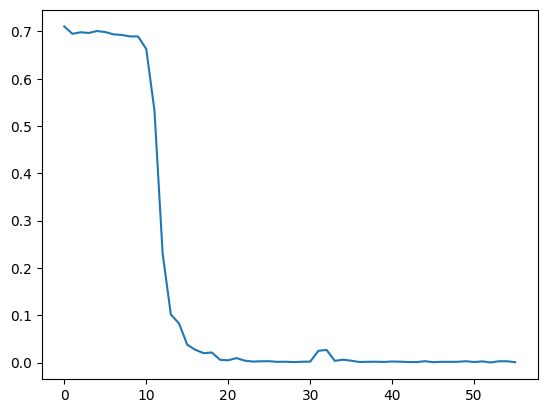

In [12]:
motif_finder = nn.Sequential (
    nn.Conv1d(in_channels=5, out_channels=20, kernel_size=5),
    nn.GELU(), 
    nn.MaxPool1d(2),
    nn.Conv1d(20, 40, 5),
    nn.GELU(),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(), 
    # linear layers
    nn.Linear(40, 128),
    nn.GELU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 64),
    nn.GELU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 8),
    nn.GELU(),
    nn.Dropout(p=0.2),
    nn.Linear(8, 2),
)

epochs = 56
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(motif_finder.parameters(), lr = learning_rate)

# training loop
train_loader_len = len(train_loader)
# print(train_loader_len)

epoch_values, loss_values = [], []

motif_finder.train()
for epoch in range(epochs):
    epoch_loss = 0
    # forward pass
    for train_features, train_labels in train_loader:
        y_hat = motif_finder(train_features)
        loss = loss_fn(y_hat, train_labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item()
    avg_loss = epoch_loss/train_loader_len
    epoch_values.append(epoch)
    loss_values.append(avg_loss)

import matplotlib.pyplot as plt
plt.plot(epoch_values, loss_values)

In [13]:
motif_finder.eval()
with torch.no_grad():
    train_model = motif_finder(X_train_tensor)
    test_model = motif_finder(X_test_tensor)

train_pred = torch.argmax(train_model, dim = 1)

test_pred = torch.argmax(test_model, dim = 1)


from sklearn.metrics import accuracy_score
print("Accuracy scores: ")

print("Accuracy score for CNN: ")
train_as = accuracy_score(train_pred, y_train)
test_as = accuracy_score(test_pred, y_test)
print("train: ", train_as)

# overfitting af, I think I know why
print("test: ", test_as)

Accuracy scores: 
Accuracy score for CNN: 
train:  1.0
test:  0.995


#### What can you do with this model?
Once you've trained the model, you can save it ( see https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html ). Now, get your own sequences of 500-size k-mers. You can change the size too, see README for details. For each 500 size k-mer, you can detect the motif of interest. 